# The Art and Science of Modeling Human Decision-Making 

**Abstract:** Computational models are immensely useful for improving our understanding of the human mind, but working with such models can also be daunting. The goal of this tutorial is to familiarize you with a general set of tools that allow you to harvest the power of computational modeling in your own research projects. In the first part, I will demonstrate how to turn verbal theories into computational models on an example decision-making problem. The second part then covers how these models can be used to draw inferences about human decision-making processes. Part of the session will be interactive, so be sure to have a working version of Python together with the NumPy library installed.

In [1]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
class TwoArmedGaussianBandit:
    def __init__(self, mean_var, reward_var):
        self.reward_var = reward_var
        
        # sample mean rewards
        self.mean = np.random.normal(loc=0, scale=math.sqrt(mean_var), size=(2,))
    
    def sample_reward(self, action):
        """
        Args:
            action (int): the selected action.

        Returns:
            float: the recevied reward.
        """

        reward = np.random.normal(self.mean[action], math.sqrt(self.reward_var))
        return reward

## Exercise 1: Implement the Bayesian updating equation

We assume normally-distributed priors and likelihoods. In this case, the posterior will also be normally-distributed and the updating equations are defined as follows:

$$ \alpha_t = \dfrac{s_{a_t}^2}{s_{a_t}^2 + \sigma^2}$$

$$(m_a, s_a^2)= 
\begin{cases}
    (m_a, s_a^2) & \text{if } a_t \neq a\\
    (m_a + \alpha_t (r_t - m_a), s_a^2 - \alpha_t s_a^2)              & \text{if } a_t = a
\end{cases}$$

We furthermore assume that $\sigma^2 = 10$ and initialize $m_a = 0$ and $s_a^2=100$ for our analyses.

In [3]:
class BayesianLearner:
    def __init__(self, mean_var, reward_var, num_actions):
        self.prior_mean = np.zeros(num_actions)
        self.prior_var = mean_var * np.ones(num_actions)
        self.reward_var = reward_var
        
    def update(self, action, reward):
        """
        Args:
            action (int): the selected action.
            reward (float): the observed reward.
        """
        alpha = self.prior_var[action] / (self.prior_var[action] + self.reward_var)
        self.prior_mean[action] = self.prior_mean[action] + alpha * (reward - self.prior_mean[action])
        self.prior_var[action] =  self.prior_var[action] - alpha * self.prior_var[action]

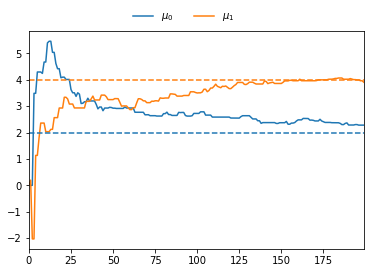

In [4]:
# initialize bandit environment
bandit = TwoArmedGaussianBandit(mean_var=100, reward_var=10)

# initialize agent
agent = BayesianLearner(mean_var=100, reward_var=10, num_actions=2)

# artifically set the means to 2 and 4 respectively. 
bandit.mean = np.array([2, 4])

time_steps = 200
mean = np.zeros((time_steps, 2))

for t in range(time_steps):
    # store agent's believes
    mean[t] = agent.prior_mean
    
    # sample a random choice
    action = np.random.choice([0, 1])
    
    # simulate rewards
    reward = bandit.sample_reward(action)   
    
    # update agent's believes
    agent.update(action, reward)

# plot the results
plt.plot(mean)
plt.axhline(y=bandit.mean[0], color='C0', ls='--')
plt.axhline(y=bandit.mean[1], color='C1', ls='--')
plt.legend([r'$\mu_0$', r'$\mu_1$'], frameon=False, bbox_to_anchor=(0.3, 1.02, 1, 0.2), loc="lower left",
               borderaxespad=0, ncol=2)
plt.xlim(0, time_steps-1)
plt.show()

## Exercise 2: Implement the exploitation strategy

Pure exploitation picks the action with highest expected reward:

$$a_t = \text{arg}\max_{a \in \mathcal{A}} m_a$$

In [5]:
class BayesianLearner:
    def __init__(self, mean_var, reward_var, num_actions):
        self.prior_mean = np.zeros(num_actions)
        self.prior_var = mean_var * np.ones(num_actions)
        self.reward_var = reward_var
        
    def update(self, action, reward):
        """
        Args:
            action (int): the selected action.
            reward (float): the observed reward.
        """
        alpha = self.prior_var[action] / (self.prior_var[action] + self.reward_var)
        self.prior_mean[action] = self.prior_mean[action] + alpha * (reward - self.prior_mean[action])
        self.prior_var[action] =  self.prior_var[action] - alpha * self.prior_var[action]

class PureExploitation(BayesianLearner):
    def __init__(self, mean_var, reward_var, num_actions):
        super().__init__(mean_var, reward_var, num_actions)
        
    def act(self):
        """
        Returns:
            int: the selected action.
        """
        return np.argmax(self.prior_mean)

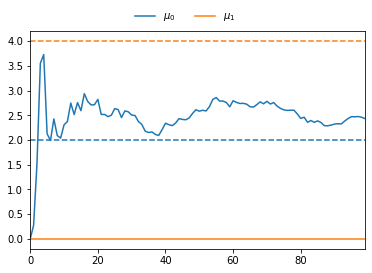

In [6]:
# initialize bandit environment
bandit = TwoArmedGaussianBandit(mean_var=100, reward_var=10)

# initialize agent
agent = PureExploitation(mean_var=100, reward_var=10, num_actions=2)

# artifically set the means to 2 and 4 respectively. 
bandit.mean = np.array([2, 4])

time_steps = 100
mean = np.zeros((time_steps, 2))

for t in range(time_steps):
    # store agent's believes
    mean[t] = agent.prior_mean
    
    # act according to the agent's strategy
    action = agent.act()
    
    # simulate rewards
    reward = bandit.sample_reward(action)   
    
    # update agent's believes
    agent.update(action, reward)
    
# plot the results
plt.plot(mean)
plt.legend([r'$\mu_0$', r'$\mu_1$'], frameon=False, bbox_to_anchor=(0.3, 1.02, 1, 0.2), loc="lower left",
               borderaxespad=0, ncol=2)
plt.axhline(y=bandit.mean[0], color='C0', ls='--')
plt.axhline(y=bandit.mean[1], color='C1', ls='--')
plt.xlim(0, time_steps-1)
plt.show()

## Exercise 3: Implement Boltzmann exploration

Boltzmann exploration applies the sigmoid function to the scaled reward difference and samples from the resulting probability distribution:

$$a_t \sim p(A_t)$$

$$p(A_t = 0) = \sigma(w\left(m_0 - m_1\right))$$

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class BoltzmannExploration(BayesianLearner):
    def __init__(self, mean_var, reward_var, num_actions, w=1):
        super().__init__(mean_var, reward_var, num_actions)
        self.w = w
        
    def act(self):
        """
        Returns:
            int: the selected action.
        """
        p0 = sigmoid(self.w*(self.prior_mean[0] - self.prior_mean[1]))
        return np.random.choice([0, 1], p=[p0, 1 - p0])

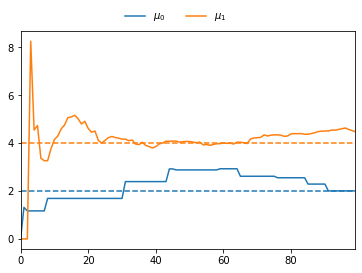

In [8]:
# initialize bandit environment
bandit = TwoArmedGaussianBandit(mean_var=100, reward_var=10)

# initialize agent
agent = BoltzmannExploration(mean_var=100, reward_var=10, num_actions=2)

# artifically set the means to 2 and 4 respectively. 
bandit.mean = np.array([2, 4])

time_steps = 100
mean = np.zeros((time_steps, 2))

for t in range(time_steps):
    # store agent's believes
    mean[t] = agent.prior_mean
    
    # act according to the agent's strategy
    action = agent.act()
    
    # simulate rewards
    reward = bandit.sample_reward(action)   
    
    # update agent's believes
    agent.update(action, reward)
    
# plot the results
plt.plot(mean)
plt.legend([r'$\mu_0$', r'$\mu_1$'], frameon=False, bbox_to_anchor=(0.3, 1.02, 1, 0.2), loc="lower left",
               borderaxespad=0, ncol=2)
plt.axhline(y=bandit.mean[0], color='C0', ls='--')
plt.axhline(y=bandit.mean[1], color='C1', ls='--')
plt.xlim(0, time_steps-1)
plt.show()

## Exercise 4: Implement the UCB strategy and Thompson sampling

Thompson sampling samples actions relative to their probablity of being correct:

$$ a_t \sim p(A_t)$$

$$ p(A_t = 0) = p(\mu_0 > \mu_1) = \phi\left(\frac{m_0 - m_1}{\sqrt{s_0^2 + s_1^2}}\right)$$

UCB uses the uncertainty in the posterior distribution to guide exploration:

$$a_t = \text{arg}\max_{a \in \mathcal{A}} \left[ m_a + w s_a \right]$$

In [9]:
from scipy.stats import norm

class ThompsonSampling(BayesianLearner):
    def __init__(self, mean_var, reward_var, num_actions):
        super().__init__(mean_var, reward_var, num_actions)
        
    def act(self):
        """
        Returns:
            int: the selected action.
        """
        p = norm.cdf((agent.prior_mean[0] - agent.prior_mean[1])/math.sqrt(agent.prior_var[0] + agent.prior_var[1]))
        return np.random.choice([0, 1], p=[p, 1 - p])

class UCB(BayesianLearner):
    def __init__(self, mean_var, reward_var, num_actions, w=1):
        super().__init__(mean_var, reward_var, num_actions)
        self.w = w
        
    def act(self):
        """
        Returns:
            int: the selected action.
        """
        return np.argmax(agent.prior_mean + self.w * np.sqrt(agent.prior_var))

In [10]:
# list of agents
agents = [PureExploitation, BoltzmannExploration, ThompsonSampling, UCB]

num_runs = 1000
time_steps = 100
regrets = np.zeros((len(agents), num_runs, time_steps))

for num_agent, agent_class in enumerate(agents):
    for run in range(num_runs):
        
        # initialize bandit environment
        bandit = TwoArmedGaussianBandit(mean_var=100, reward_var=10)
        
        # initialize agent
        agent = agent_class(mean_var=100, reward_var=10, num_actions=2)

        for t in range(time_steps):
            # act according to the agent's strategy
            action = agent.act()
            
            # simulate rewards
            reward = bandit.sample_reward(action)   
            
            # update agent's believes
            agent.update(action, reward)
            
            # store performance
            regrets[num_agent, run, t] = np.max(bandit.mean) - bandit.mean[action]

(-0.05, 2.0)

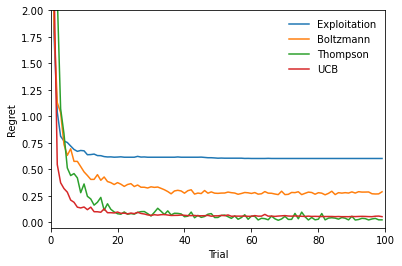

In [11]:
# plot the results
plt.plot(regrets.mean(1).T)  
plt.legend(['Exploitation', 'Boltzmann', 'Thompson', 'UCB'], frameon=False)
plt.xlabel('Trial')
plt.ylabel('Regret')
plt.xlim(0, 100)
plt.ylim(-0.05, 2.0)

## Exercise 5: Fit parameters to data

We want to fit the parameters of the following probit regression model to our data:

$$p(A_t = 0 | \mathbf{w}) = {\phi} \left(w_1 \left(m_0 - m_1 \right) {+ w_2 \left(\dfrac{m_0 - m_1}{\sqrt{s_0^2 + s_1^2}} \right)} {+ w_3 \left(s_0 - s_1 \right)}\right)$$

using maximum likelihood estimate with the following objective:

$$\mathbf{w}^* = \text{arg}\max_{\mathbf{w}}  \sum_{k, t} \log p(A_{t, k} = a_{t, k} | \mathbf{w})$$

In [12]:
import pandas as pd

def parse_data():
    """
        Parse data into numpy arrays.
        
        Returns:
            X (ndarray): numpy array of size (num_partcipants x num_tasks x num_trials x 3) containing features.
            y (ndarray): numpy array of size (num_partcipants x num_tasks x num_trials x 1) containing choices.
        """
    
    df = pd.read_csv('data/data2.csv')

    X = np.zeros((df.subject.max(), df.block.max(), df.trial.max(), 3))
    y = np.zeros((df.subject.max(), df.block.max(), df.trial.max(), 1))

    for subject in range(df.subject.max()):
        for block in range(df.block.max()):

            # initialize agent
            agent = BayesianLearner(mean_var=100, reward_var=10, num_actions=2)

            for trial in range(df.trial.max()):

                # create input features
                X[subject, block, trial, 0] = agent.prior_mean[0] - agent.prior_mean[1]
                X[subject, block, trial, 1] = X[subject, block, trial, 0] / math.sqrt(agent.prior_var[0] + agent.prior_var[1])
                X[subject, block, trial, 2] = np.sqrt(agent.prior_var)[0] - np.sqrt(agent.prior_var)[1]

                # action taken by participant
                action = int(df[(df['subject'] == subject + 1) & (df['block'] == block + 1) & (df['trial'] == trial + 1)].choice - 1)
                y[subject, block, trial, 0] = (action == 0)

                # get reward received and update beliefs
                reward = float(df[(df['subject'] == subject + 1) & (df['block'] == block + 1) & (df['trial'] == trial + 1)].reward)
                agent.update(action, reward)
    return X, y

In [13]:
from scipy.optimize import minimize

def phi(xs):
    """
        Args:
            xs (ndarray): numpy array of any size.

        Returns:
            ndarray: numpy array of the same size.
        """
    return np.clip(np.array([(1.0 + math.erf(x / math.sqrt(2.0))) / 2.0 for x in xs]), 1e-10, 1-10e-10)

def nll(w, inputs, targets):
    """
        Args:
            w (ndarray): numpy array of size (3) containing current parameter estimates.
            inputs (ndarray): numpy array of size (num_choices x 3) containing features.
            targets (ndarray): numpy array of size (num_choices) containing selected action.

        Returns:
            float: loss function for the current parameter estimates w.
        """
    probs = phi(inputs @ w[:, None][:, 0])
    return -(targets * np.log(probs) + (1-targets) * np.log(1-probs)).sum()

X, y = parse_data()
params = np.zeros((X.shape[0], X.shape[3]))

# loop over participants
for subject in range(X.shape[0]):
    
    # reshape inputs
    inputs = X[subject].reshape((200, 3))
    targets = y[subject].reshape((200))
    
    # optimize and store best-fitting regression weights
    res = minimize(nll, np.zeros(3), method='BFGS', args=(inputs, targets))
    params[subject] = res.x

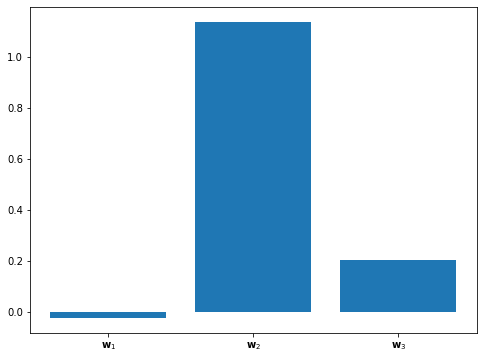

In [14]:
# plot the average regression weights
plt.rcParams["figure.figsize"] = (8,6)
plt.bar(np.arange(3), params.mean(0))
plt.xticks(np.arange(3), [r'$\mathbf{w}_1$',r'$\mathbf{w}_2$', r'$\mathbf{w}_3$'])
plt.show()

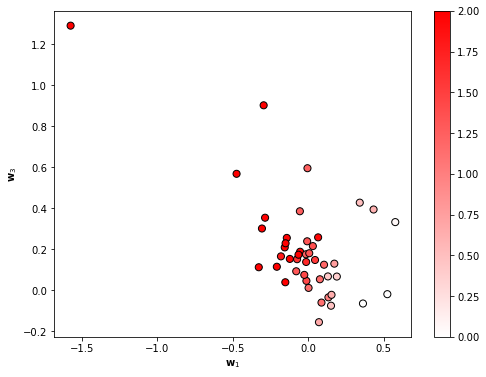

In [15]:
# create color coding
colors = np.ones_like(params)
colors[:, 1] = 1 - np.clip((params[:, 1] + 0.5) / (2 + 0.0), 0, 1)
colors[:, 2] = 1 - np.clip((params[:, 1] + 0.5) / (2 + 0.0), 0, 1)

# plot the individual regression weights
plt.scatter(params[:, 0], params[:, 2], color=colors, s=50, edgecolors= "black")

# create colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('testCmap', ['white', 'red'])
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2)

plt.xlabel(r'$\mathbf{w}_1$')
plt.ylabel(r'$\mathbf{w}_3$')
plt.colorbar(sm)

plt.show()